<a href="https://colab.research.google.com/github/GabrielaRomoM/SIGNALS-THEORY_2024-1/blob/main/RedNeuronalPSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generación de la señal x(t)

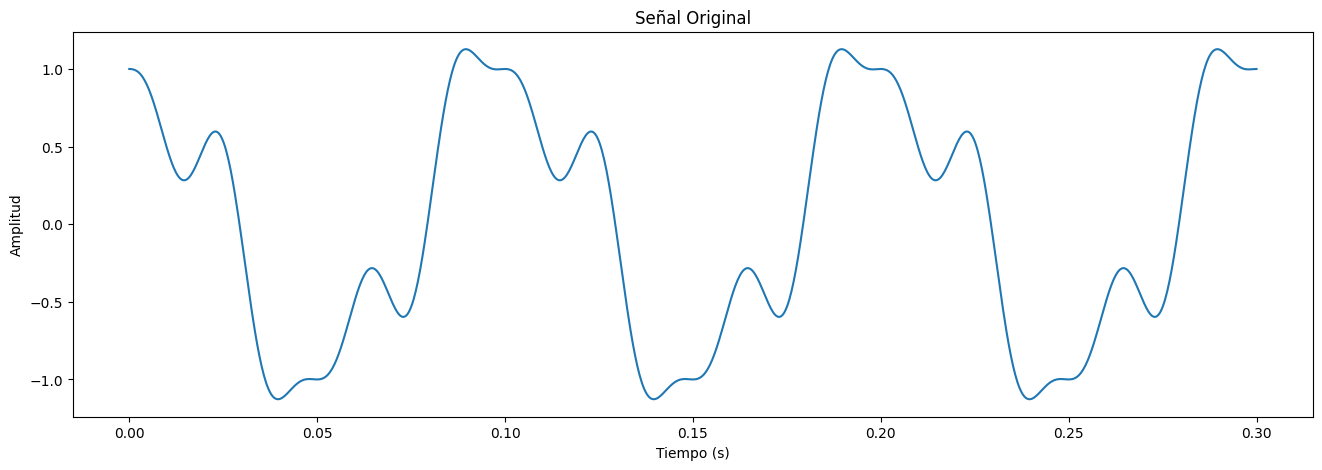

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#Frecuencia angular general y vector de tiempo
f = 10
w = 2*np.pi*f
T = 1/f
N = 1024
t = np.linspace(0,3*T,N)

#Señales particulares
x1 = np.cos(w*t)
x2 = 1/3*(np.sin(3*w*t))
x3 = 1/5*(np.sin(5*w*t))

#Señal original para la red
xt = x1-x2+x3

plt.figure(figsize=(16,5))
plt.title('Señal Original')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.plot(t,xt)
plt.show()

# Generador de Matriz

Matriz con señales x(t)+N donde 'N' es ruido blanco gaussiano.

Matriz 1000 x 1024, donde 1000 es el numero de señales 'x(t)+ N' y 1024 el numero de muestras(puntos) para cada señal.

Para variar las señales y los ruidos se manejaron 4 desviaciones estándar (0.1,0.3,1,3), generando 250 señales con ruido para cada desviación. De esta manera se tienen 1000 señales con diferentes ruidos.

In [ ]:
def generatematrixnoisysgn(xt, std_devs, sgnum, N):
    totalsgn = sgnum * len(std_devs)
    M = np.empty((totalsgn, N))

    index = 0
    for std in std_devs:
        for _ in range(sgnum):
            vectoruido = np.random.normal(0, std, N)
            sgnruido = xt + vectoruido
            M[index] = sgnruido
            index += 1
    return M

# Desviaciones estándar
std_devs = [0.1, 0.3, 1, 3]
sgnum = 250 #Cantidad de señales por desviación estándar

# Generar la matriz de señales ruidosas
M = generatematrixnoisysgn(xt, std_devs, sgnum, N)

# Figuras de muestra

Visualización de las 1000 señales ruidosas de la matriz

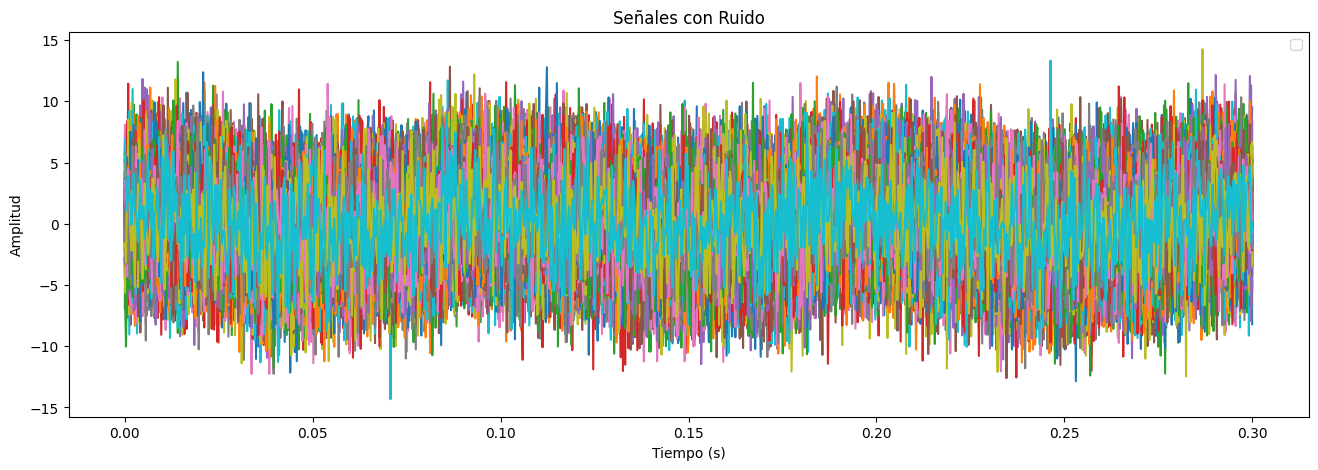

In [ ]:
#Visualización de las 1000 señales con ruido gaussiano
plt.figure(figsize=(16,5))
plt.title('Señales con Ruido')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
for i in range(0,1000,1):
    plt.plot(t,M[i])
plt.legend()
plt.show()

Visualización de algunas señales para confirmar que el ruido se haya añadido a x(t) correctamente.

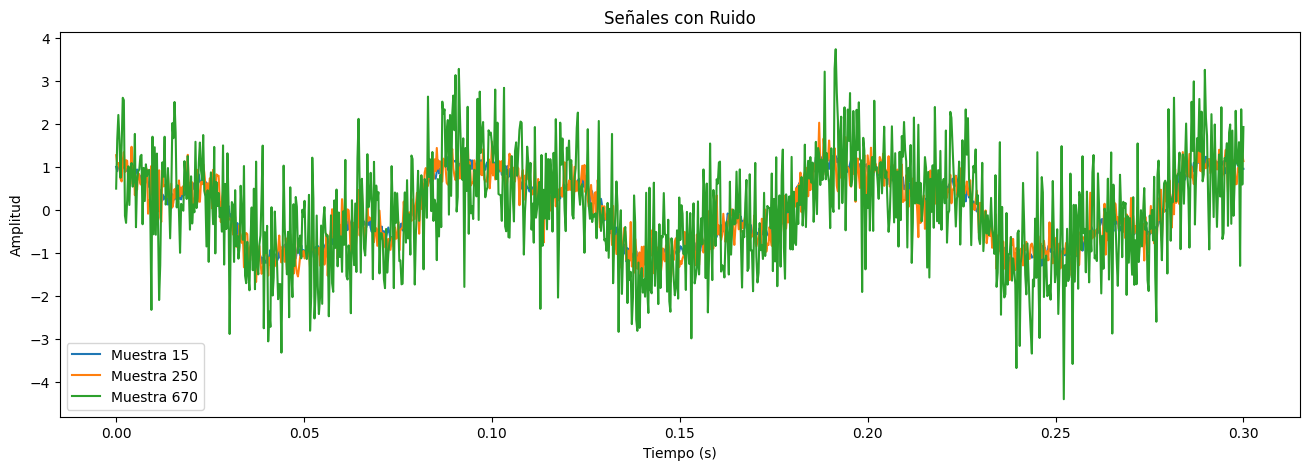

In [ ]:
#Visualización de algunas señales especificas
plt.figure(figsize=(16,5))
plt.title('Señales con Ruido')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.plot(t,M[15], label='Muestra 15')
plt.plot(t,M[250],label= 'Muestra 250')
plt.plot(t,M[670],label= 'Muestra 670')
plt.legend()
plt.show()

#Calcular PSD con Welch

Se va realizó el calculo del PSD con welch para cada señal de nuestra matriz con el fin de generar una nueva matriz con todas las psd de las señales que nos serviran como salida para el modelo de nuestra red neuronal.

También se imprimió una visualización de todos los espectros.

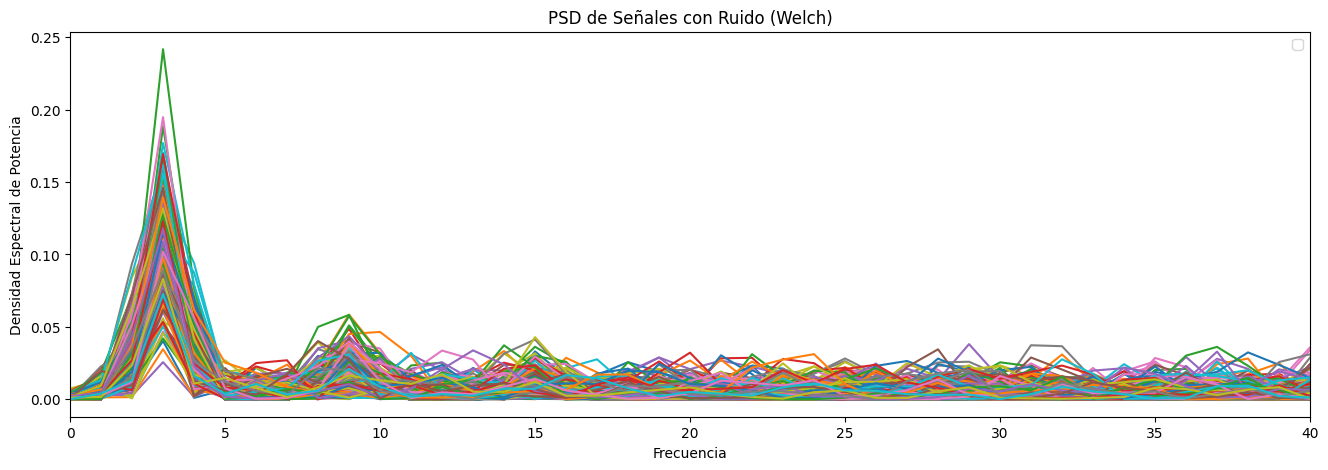

In [ ]:
from scipy.signal import welch
# Función para calcular el espectro de potencia usando el método de Welch
def welch_psd(signal, fs):
    freqs, psd = welch(signal, fs=fs, nperseg=1024)
    return psd

# Calcular la frecuencia de muestreo
fs = N / (3 * T)

# Calcular la PSD para cada señal ruidosa usando Welch
Mwelch = np.array([welch_psd(M[i], fs=fs) for i in range(M.shape[0])])

#print("Dimensiones de la matriz de PSD:", Mwelch.shape)

plt.figure(figsize=(16, 5))
plt.title('PSD de Señales con Ruido (Welch)')
plt.xlabel('Frecuencia')
plt.ylabel('Densidad Espectral de Potencia')
plt.xlim(0,40)
for i in range(0,1000,1):
   plt.plot(Mwelch[i])
plt.legend()
plt.show()

# Modelo de la red MLP para predecir PSD

- Se dividieron los datos tomando el 70% para entrenamiento y el 30% para el testeo.

- Para el modelo MLP se hizo uso de 3 capas ocultas(hidden layers) y una capa de salida. Todas las capas ocultas estan bajo la activación tipo 'relu' ya que es simple de implementar y eficiente pero esta misma es la que ocasiona algunas neuronas muertas (puntos donde se atasca y deja de aprender).

- La capa de salida utiliza una activación 'linear', se decidió usar esta ya que al ser usada en modelos de regresión y al estar trabajando con señales es la que mejor se adapta a nuestras necesidades.

- Para cada capa oculta se ha decidido iniciar con una cantidad amplia de neuronas y con el fin de evitar el sobreajuste se va disminuyendo la cantidad hasta un valor un poco más pequeño. Se ha usado 256, 128 y 64 neuronas en orden de capas (1,2,3).

- Para la capa de salida se ha hecho con Mwelch.shape[1] Neuronas ya que la cantidad de neuronas en la capa de salida es igual a la cantidad de puntos en la PSD esta tratando de predecir. Cada neurona en la capa de salida corresponde a un punto en el espectro de frecuencia.

- Para la compilación del modelo se ha usado un loss de tipo mse(mean square error) porque es el metodo más adecuado para el manejo de señales.

- El learning rate en 0.0001 al ser bajo permite una convergencia más estable aunque esto puede implicar que sea el proceso más lento.

- Se intentó poner un número de épocas no muy alto para evitar el sobreajuste, haciendo otros intentos a partir de la 20-30 epoca el modelo dejaba de aprender.

- En el caso del batch size se decidió usar un valor alto en relación a la cantidad de épocas usadas, para que haya una estimación más estable. Valores más altos ralentizaban mucho el proceso y con valores más bajos el modelo no aprendía.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(M, Mwelch, test_size=0.3, random_state=42)

#Construcción del modelo MLP
model= Sequential()
model.add(Dense(256,input_dim=N, activation = 'relu')) # 1ra capa oculta (hidden layer)
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(Mwelch.shape[1], activation = 'linear')) # Capa de salida

#Compilación del modelo
model.compile(loss='mse',optimizer=Adam(learning_rate=0.0001), metrics=['acc'])

# Entrenamiento del modelo
history = model.fit(X_train, Y_train, epochs=25, batch_size=15, validation_split = 0.2)

Epoch 1/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - acc: 0.0000e+00 - loss: 0.1428 - val_acc: 0.0000e+00 - val_loss: 0.0375
Epoch 2/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.0047 - loss: 0.0237 - val_acc: 0.0071 - val_loss: 0.0213
Epoch 3/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.0186 - loss: 0.0091 - val_acc: 0.1786 - val_loss: 0.0155
Epoch 4/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.2217 - loss: 0.0041 - val_acc: 0.3786 - val_loss: 0.0123
Epoch 5/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc: 0.3984 - loss: 0.0019 - val_acc: 0.4571 - val_loss: 0.0104
Epoch 6/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.4383 - loss: 0.0012 - val_acc: 0.5357 - val_loss: 0.0092
Epoch 7/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.5530 - loss: 5.6264e-04 - val_acc: 0.5786 - val_loss: 0.0084
Epoch 8/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.6184 - loss: 3.6328e-04 - val_acc: 0.6071 - val_loss: 0.0080
Epoch 9/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

# Loss

Perdida de Entrenamiento y Validación.

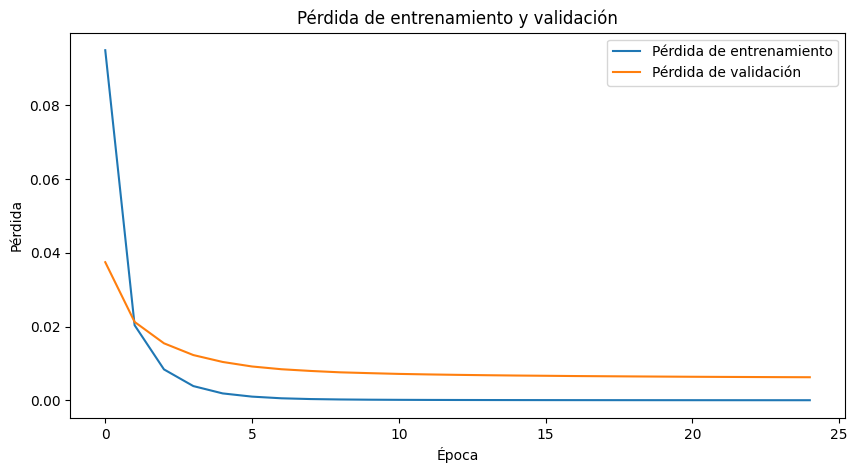

In [ ]:
# Visualización de la pérdida de entrenamiento y validación
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Pérdida de entrenamiento y validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

# Accuracy

Precisión del entrenamiento y validación.

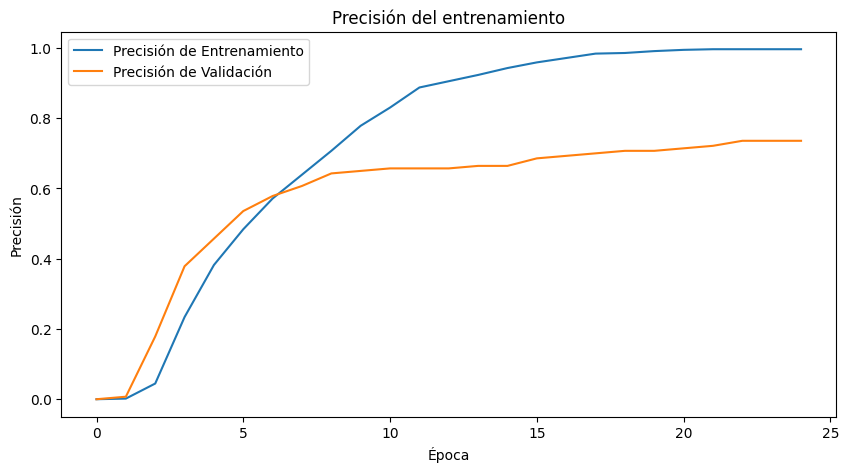

In [ ]:
#Visualización de la precisión del modelo
plt.figure(figsize=(10, 5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Precisión del entrenamiento')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Precisión de Entrenamiento', 'Precisión de Validación'])
plt.show()

# Evaluación del modelo

Revisión del procentaje de precisión alcanzado con el entrenamiento y visualización de un resultado de PSD estimada con el modelo.

In [ ]:
test_loss, test_acc = model.evaluate(X_test, Y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.7209 - loss: 0.0074 
Test Loss: 0.00728567922487855, Test Accuracy: 0.7133333086967468


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


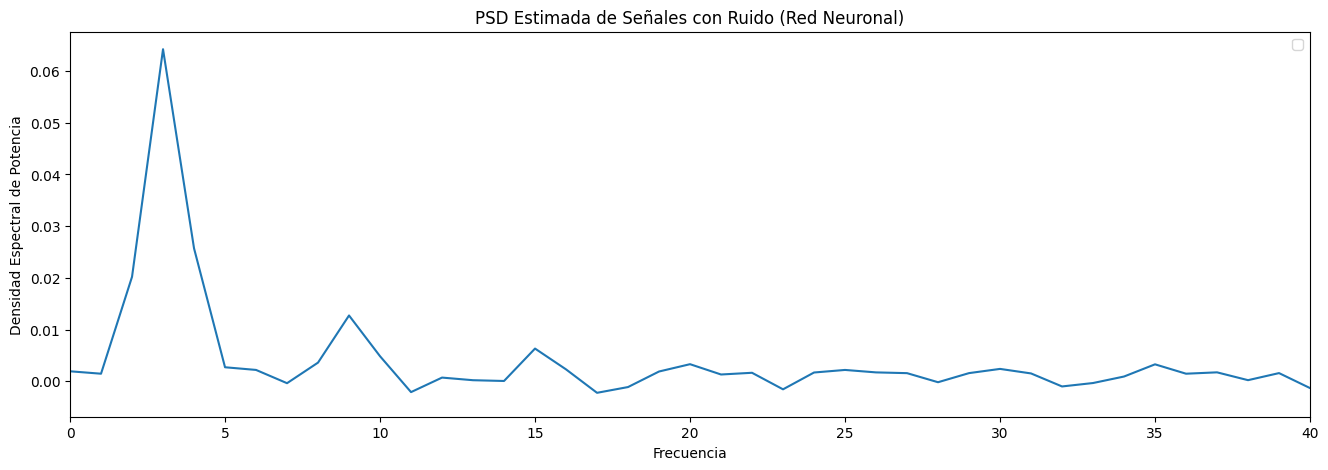

In [ ]:
# Mostrar la PSD estimada de las señales ruidosas
y_pred_all = model.predict(X_test)

plt.figure(figsize=(16, 5))
plt.title('PSD Estimada de Señales con Ruido (Red Neuronal)')
plt.xlabel('Frecuencia')
plt.ylabel('Densidad Espectral de Potencia')
plt.xlim(0,40)
plt.plot(y_pred_all[60])
plt.legend()
plt.show()